# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
%cd /mnt/disks/user/project/PROJECT/
#!rm -rf model_init_conv_lstm_2019-12-2311_42_08.483251

/mnt/disks/user/project/PROJECT


In [2]:
!pip install livelossplot

You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import cv2

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size
num_of_images_in_video_frames = 16
image_width = 120
image_height = 120

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,num_of_images_in_video_frames,image_width,image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [8]:
def read_batch_image(source_path, img_idx, folder_list, batch, batch_size, ):  
    batch_data,batch_labels = init_batch_data(batch_size)
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = imresize(image, (image_width,image_height)).astype(np.float32)
            norm2_image = image - np.min(image)/np.max(image) - np.min(image)
            batch_data[folder,idx,:,:,0] = image[:, :, 0]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = image[:, :, 1]/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = image[:, :, 2]/255 #normalise and feed in the image
            
        batch_labels[folder, int(folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels 

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,15,16,18,20,22,24,26,28]#[x for x in range(0, 30)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield read_batch_image(source_path, img_idx, t, batch, batch_size) #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield read_batch_image(source_path, img_idx, t, batch, batch_size)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout,GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalMaxPooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here
nb_filters = [64,128]
nb_dense = [256, 128, 5]

# Input
input_shape=(num_of_images_in_video_frames,image_width,image_height,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 kernel_initializer='he_uniform',
                 input_shape=input_shape,
                 activation = "relu",
                 padding='same'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 kernel_initializer='he_uniform',
                 activation = "relu",
                 padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(GlobalMaxPooling3D())

model.add(Dense(nb_dense[0], kernel_regularizer=l2(0.01),
                 kernel_initializer='he_uniform',
                 activation = "relu",))
model.add(Activation('relu'))

model.add(Dropout(0.5))
#softmax layer
model.add(Dense(nb_dense[2],
                 activation = "softmax"))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
from keras.optimizers import Adam
from keras.optimizers import SGD
optimiser = Adam(lr=0.0008)
#optimiser = Adam(lr=0.00086) #write your optimizerv .. (1) changed from 80 to 88
#optimiser = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 64)  5248      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 128)    221312    
_________________________________________________________________
global_max_pooling3d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.20, patience=5, cooldown=1, verbose=1, mode='auto', min_delta=0.0001)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, cooldown=1, verbose=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
def build_cnn_model(epoch, batch_sz):
    train_generator = generator(train_path, train_doc, batch_sz)
    val_generator = generator(val_path, val_doc, batch_sz)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_sz)
    else:
        steps_per_epoch = (num_train_sequences//batch_sz) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_sz)
    else:
        validation_steps = (num_val_sequences//batch_sz) + 1
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
#build_cnn_model(epoch=50, batch_sz=60)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/100


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


67/67 [==============================] - 154s 2s/step - loss: 6.3968 - categorical_accuracy: 0.2433 - val_loss: 5.1005 - val_categorical_accuracy: 0.4727

Epoch 00001: saving model to model_init_2019-12-2316_16_24.941680/model-00001-6.40455-0.24585-5.10054-0.47273.h5
Epoch 2/100
67/67 [==============================] - 15s 231ms/step - loss: 4.8051 - categorical_accuracy: 0.3433 - val_loss: 4.2697 - val_categorical_accuracy: 0.3273

Epoch 00002: saving model to model_init_2019-12-2316_16_24.941680/model-00002-4.80508-0.34328-4.26974-0.32727.h5
Epoch 3/100
67/67 [==============================] - 16s 237ms/step - loss: 4.0061 - categorical_accuracy: 0.3980 - val_loss: 3.5417 - val_categorical_accuracy: 0.5091

Epoch 00003: saving model to model_init_2019-12-2316_16_24.941680/model-00003-4.00611-0.39801-3.54174-0.50909.h5
Epoch 4/100
67/67 [==============================] - 16s 232ms/step - loss: 3.4851 - categorical_accuracy: 0.4179 - val_loss: 3.0600 - val_categorical_accuracy: 0.5273



Epoch 00029: saving model to model_init_2019-12-2316_16_24.941680/model-00029-0.63877-0.88557-0.91066-0.71818.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 30/100
67/67 [==============================] - 15s 227ms/step - loss: 0.6607 - categorical_accuracy: 0.8706 - val_loss: 0.8641 - val_categorical_accuracy: 0.7364

Epoch 00030: saving model to model_init_2019-12-2316_16_24.941680/model-00030-0.66068-0.87065-0.86413-0.73636.h5
Epoch 31/100
67/67 [==============================] - 16s 235ms/step - loss: 0.6556 - categorical_accuracy: 0.8657 - val_loss: 0.8802 - val_categorical_accuracy: 0.7273

Epoch 00031: saving model to model_init_2019-12-2316_16_24.941680/model-00031-0.65559-0.86567-0.88019-0.72727.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 32/100
67/67 [==============================] - 16s 242ms/step - loss: 0.5677 - categorical_accuracy: 0.9104 - val_loss: 0.8203 - val_categorical_accura


Epoch 00055: saving model to model_init_2019-12-2316_16_24.941680/model-00055-0.57398-0.91045-0.83542-0.75455.h5
Epoch 56/100
67/67 [==============================] - 15s 230ms/step - loss: 0.5334 - categorical_accuracy: 0.9353 - val_loss: 0.8036 - val_categorical_accuracy: 0.8000

Epoch 00056: saving model to model_init_2019-12-2316_16_24.941680/model-00056-0.53345-0.93532-0.80361-0.80000.h5

Epoch 00056: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 57/100
67/67 [==============================] - 15s 225ms/step - loss: 0.5818 - categorical_accuracy: 0.8955 - val_loss: 0.8148 - val_categorical_accuracy: 0.7818

Epoch 00057: saving model to model_init_2019-12-2316_16_24.941680/model-00057-0.58176-0.89552-0.81477-0.78182.h5
Epoch 58/100
67/67 [==============================] - 15s 226ms/step - loss: 0.6016 - categorical_accuracy: 0.9005 - val_loss: 0.8370 - val_categorical_accuracy: 0.7727

Epoch 00058: saving model to model_init_2019-12-2316_16_24.941680/mod

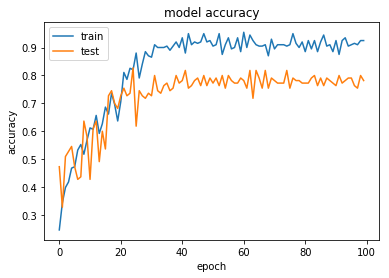

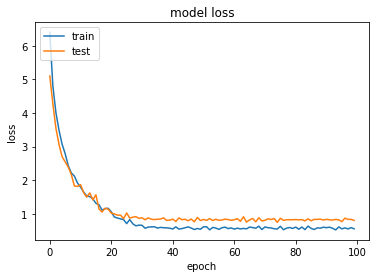

In [16]:
build_cnn_model(epoch=100, batch_sz=10)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
rnn_batch_sz = 25
rnn_num_epochs = 70
rnn_num_of_images_in_video_frames = 15
def rnn_init_batch_data(batch_size):
    batch_data = np.zeros((batch_size,rnn_num_of_images_in_video_frames,image_width,image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels
def rnn_read_batch_image(source_path, img_idx, folder_list, batch, batch_size, ):  
    batch_data,batch_labels = rnn_init_batch_data(batch_size)
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folder_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = imresize(image, (image_width,image_height)).astype(np.float32)
            norm2_image = image - np.min(image)/np.max(image) - np.min(image)
            batch_data[folder,idx,:,:,0] = norm2_image[:, :, 0] #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = norm2_image[:, :, 1] #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = norm2_image[:, :, 2] #normalise and feed in the image
            
        batch_labels[folder, int(folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels 
def rnn_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield rnn_read_batch_image(source_path, img_idx, t, batch, batch_size) #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield rnn_read_batch_image(source_path, img_idx, t, batch, batch_size)

input_shape=(rnn_num_of_images_in_video_frames,image_width,image_height,3)
train_generator = rnn_generator(train_path, train_doc, rnn_batch_sz)
val_generator = rnn_generator(val_path, val_doc, rnn_batch_sz)
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/rnn_batch_sz)
else:
    steps_per_epoch = (num_train_sequences//rnn_batch_sz) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/rnn_batch_sz)
else:
    validation_steps = (num_val_sequences//rnn_batch_sz) + 1    
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(image_width,image_height,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(128, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model_rnn = Sequential()
model_rnn.add(TimeDistributed(conv_model, input_shape=input_shape))
model_rnn.add(GRU(64, return_sequences=True))
model_rnn.add(GRU(32))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(8, kernel_regularizer=l2(0.01),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model_rnn.add(Dropout(0.25))
model_rnn.add(Dense(5, kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))



#optimiser = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.7, nesterov=True)
optimiser = Adam(lr=0.00085) #write your optimizer
model_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_rnn.summary())



history = model_rnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=rnn_num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()